### Loading libraries

In [1]:
import pandas as pd 
import numpy as np
# import torch
import h5py
# print("PyTorch version:", torch.__version__)
import glob
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras import backend as K
import pickle

### Extracting informations from a random image

In [61]:
path="./archive/TrainData/img/image_30.h5"
path_mask="./archive/TrainData/mask/mask_30.h5"

ls :  ['img']
<HDF5 dataset "img": shape (128, 128, 14), type "<f8">
Data Shape :  (128, 128, 14)

Total channels of each pixel per features image: 14 

Values overview :
 [0.79509819 0.77125338 0.85918894 0.77048716 0.98009116 1.02989201
 0.96355723 0.99519797 1.6051609  2.21046407 0.73789251 0.6770481
 1.57695418 3.72526248]



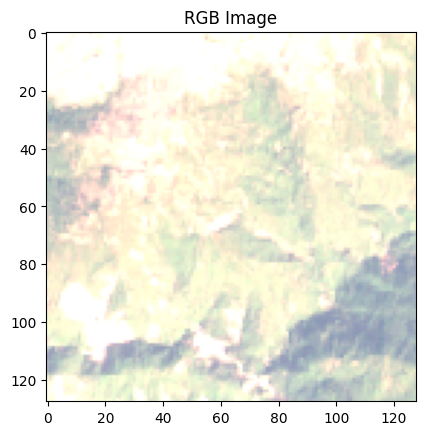

In [62]:
with h5py.File(path) as item:
    print("ls : ",list(item.keys()))
    print(item.get('img'))
    data=np.array(item.get('img'))
    print("Data Shape : ",data.shape)
    plt.title("RGB Image")
    plt.imshow(data[:, :, 3:0:-1].astype(np.float32))

my_x=(data[127][127])
# for x in my_x:print(x)
print("\nTotal channels of each pixel per features image:",len(my_x),"\n")
print(f"Values overview :\n {my_x}\n")

Shape: (128, 128, 14)
This indicates that the dataset has three dimensions:
The first dimension has a size of 128, representing the height of the image.
The second dimension has a size of 128, representing the width of the image.
The third dimension has a size of 14, indicating that there are 14 channels or layers in the image data.

"<f8" 
 specifies the data type of the elements in the dataset. "<f8" 
stands for a floating-point number with 8 bytes of precision, which typically corresponds to a 64-bit floating-point number (double-precision floating-point number).

### Examining the relationship/similarities between landslides and NDVI

NDVI shape:  (128, 128) f_data shape : (1, 128, 128, 3)
ls :  ['mask']
<HDF5 dataset "mask": shape (128, 128), type "|u1">
Shape :  (128, 128)


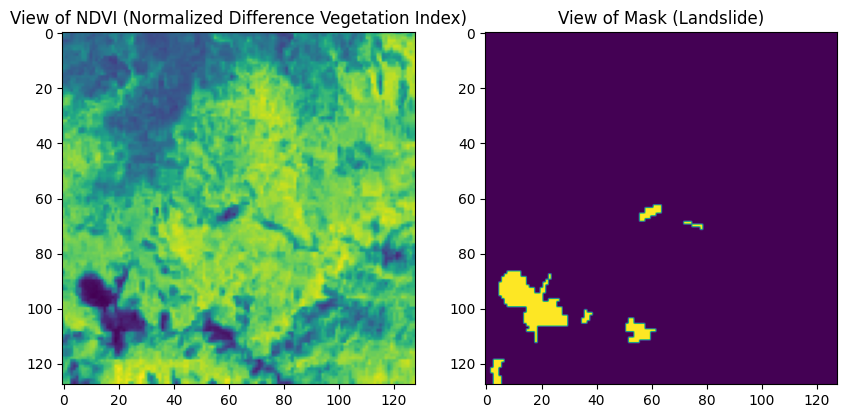

In [63]:
def ndvi_mask(data):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
    ax1.set_title("View of NDVI (Normalized Difference Vegetation Index)")
    ax2.set_title("View of Mask")
    f_data = np.zeros((1, 128, 128, 3))
    # R G B
    data_red = data[:, :, 3]  # 3rd one is red band
    data_green = data[:, :, 2]  # 2nd one is green band
    data_blue = data[:, :, 1]  # 1st one is blue band
    data_nir = data[:, :, 7]
    data_rgb = data[:, :, 3:0:-1]
    data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))
    f_data[0, :, :, 0] = data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]
    print("NDVI shape: ", data_ndvi.shape, "f_data shape :", f_data.shape)
    plt.subplot(1, 2, 1)
    plt.title("View of NDVI (Normalized Difference Vegetation Index)")
    ax1.imshow(data_ndvi) 
    
    with h5py.File(path_mask) as item:  # yellow denotes landslides 
        ls = list(item.keys())
        print("ls : ", ls)
        print(item.get('mask'))
        data2 = np.array(item.get('mask'))
        print("Shape : ", data2.shape)
        plt.subplot(1, 2, 2)
        plt.title("View of Mask (Landslide)")
        # plt.imshow(data2)
        ax2.imshow(data2)
    plt.show()
ndvi_mask(data)

In [64]:
# def ndvi_mask(data):
#     f_data=np.zeros((1,128,128,3))
#     # R G B
#     data_red=data[:,:,3] # 3rd one is red band
#     data_green=data[:,:,2] # 2nd one is green band
#     data_blue=data[:,:,1] # 1st one is blue band
#     data_nir=data[:,:,7]
#     data_rgb=data[:,:,3:0:-1]
#     data_ndvi=np.divide(data_nir-data_red,np.add(data_nir,data_red))
#     f_data[0,:,:,0]=data_ndvi
#     f_data[0,:,:,1]=data[:,:,12]
#     f_data[0,:,:,2]=data[:,:,13]
#     print("NDVI shape: ",data_ndvi.shape,"f_data shape :",f_data.shape)
#     plt.title("View of NDVI (Normalized Difference Vegetation Index):")
#     plt.imshow(data_ndvi)
#     plt.show()
#     with h5py.File(path_mask) as item: # yellow denotes landslides 
#         ls=list(item.keys())
#         print("ls : ",ls)
#         print(item.get('mask'))
#         data2=np.array(item.get('mask'))
#         print("Shape : ",data2.shape)
#         plt.title("View of Mask")
#         plt.imshow(data2)
#         plt.show()
# ndvi_mask(data)

In [65]:
train_features="./archive/TrainData/img/*.h5"
train_labels="./archive/TrainData/mask/*.h5"
if len(glob.glob(train_features))== len(glob.glob(train_labels)):
    total_fl =len(glob.glob(train_labels))
    print(f"Number of Features = Number of Labels = { total_fl }")
    train_yy=np.zeros((total_fl,128,128,1))
    train_xx=np.zeros((total_fl,128,128,6)) # 3799 img and mask
    X=sorted(glob.glob(train_features))
    Y=sorted(glob.glob(train_labels))
    print("Sorted the Features and Lebels for easy one-to-one mapping based on index")
else:
    raise "Number of Features and Lebels must be same "

Number of Features = Number of Labels = 3799
Sorted the Features and Lebels for easy one-to-one mapping based on index


### Loading Features (6 channel) & Labels (1 channel) using numpy for training & testing

In [66]:
def load_files(X, Y, limit=total_fl):
    for i,(img,mask) in enumerate(zip(X,Y)):
        if i>limit:break
        
        with h5py.File(img) as input:
            data=np.array(input.get('img'))
            # assigning for nan value
            data[np.isnan(data)]=0.000001

            # normalize data with divide by 0 error handeling
            mid_rgb=max(data[:,:,1:4].max() / 2.0, 0.000001)
            mid_slope=max(data[:,:,12].max() / 2.0, 0.000001)
            mid_elevation=max(data[:,:,13].max() / 2.0, 0.000001)

            # ndvi calculations with divide by 0 error handeling
            data_red=data[:,:,3]
            data_nir=data[:,:,7] # near infrared
            data_ndvi=np.divide(data_nir - data_red, np.add(data_red, data_nir) + 0.000001)
            # adding to the final array
            train_xx[i,:,:,0]=1-data[:,:,3]/mid_rgb # red
            train_xx[i,:,:,1]=1-data[:,:,2]/mid_rgb # green
            train_xx[i,:,:,2]=1-data[:,:,1]/mid_rgb # blue
            train_xx[i,:,:,3]=data_ndvi # ndvi
            train_xx[i,:,:,4]=1-data[:,:,12]/mid_slope # slope
            train_xx[i,:,:,5]=1-data[:,:,13]/mid_elevation # elevation
        with h5py.File(mask) as label:
            ls2=list(label.keys())
            data2=np.array(label.get('mask'))
            train_yy[i,:,:,0]=data2

        if i% (limit//5) ==0: # printing in each 1/5 = 20% completion
            print(i+1,img,mask)
            print("RGB pixel max value =",data[:,:,1:4].max())
            print("RGB pixel min value =",data[:,:,1:4].min())
    return train_xx, train_yy
train_xx, train_yy= load_files(X, Y)

1 ./archive/TrainData/img\image_1.h5 ./archive/TrainData/mask\mask_1.h5
RGB pixel max value = 4.829584218436117
RGB pixel min value = 0.9861337078574212
760 ./archive/TrainData/img\image_1682.h5 ./archive/TrainData/mask\mask_1682.h5
RGB pixel max value = 3.7513514626922397
RGB pixel min value = 0.5054216042549425
1519 ./archive/TrainData/img\image_2365.h5 ./archive/TrainData/mask\mask_2365.h5
RGB pixel max value = 2.6776113434306286
RGB pixel min value = 0.44027837526208324
2278 ./archive/TrainData/img\image_3048.h5 ./archive/TrainData/mask\mask_3048.h5
RGB pixel max value = 2.48892061117545
RGB pixel min value = 0.6132448798293303
3037 ./archive/TrainData/img\image_3731.h5 ./archive/TrainData/mask\mask_3731.h5
RGB pixel max value = 4.041126515798407
RGB pixel min value = 0.7300534283682503
3796 ./archive/TrainData/img\image_996.h5 ./archive/TrainData/mask\mask_996.h5
RGB pixel max value = 26.320110831356274
RGB pixel min value = 0.4232192307830079


In [67]:
train_xx[np.isnan(train_xx)]=0.000001
print(len(train_xx),train_xx.min(),train_xx.max(),train_yy.min(),train_yy.max())

3799 -1.0 1.0 0.0 1.0


In [68]:
def dice_loss(y_true,y_pred): # dice loss function
    y_true=tf.cast(y_true,tf.float32)
    y_pred=tf.math.sigmoid(y_pred)
    numerator=2*tf.reduce_sum(y_true*y_pred)
    denominator=tf.reduce_sum(y_true*y_pred)
    return 1- numerator/denominator

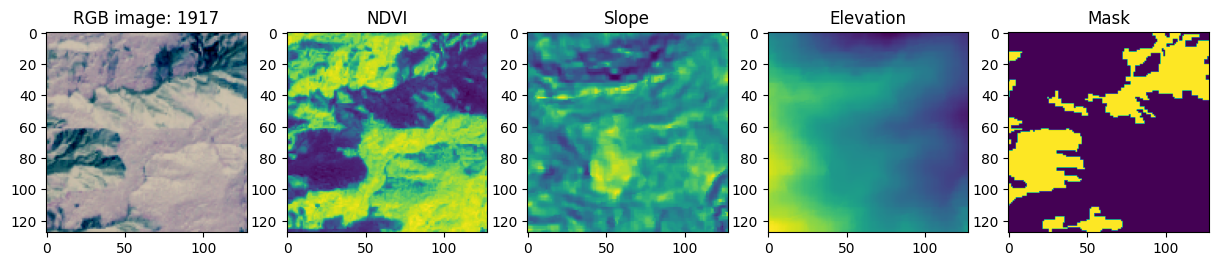

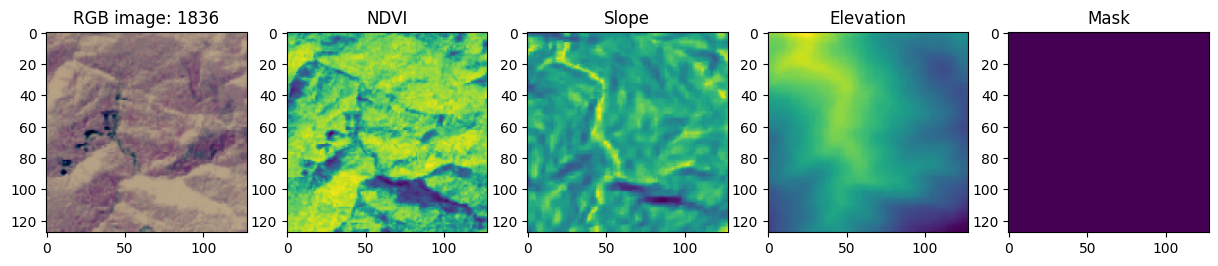

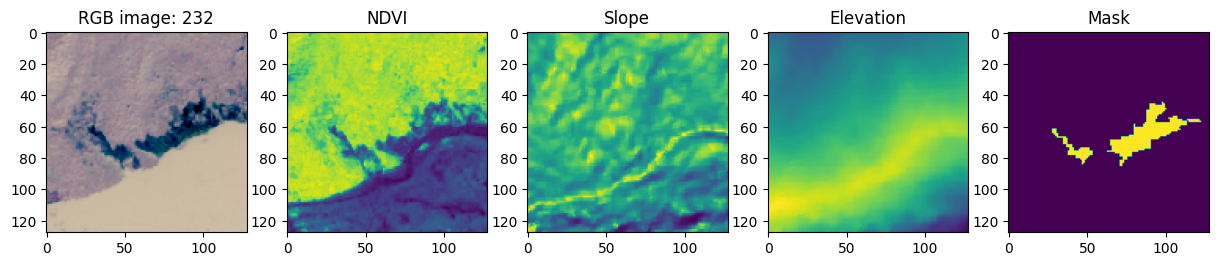

In [69]:
# visualization of training data
def visualize_data(img=232):
    fig,(ax1,ax2,ax3,ax4,ax5)=plt.subplots(1,5,figsize=(15,10))
    ax1.set_title(f"RGB image: {img}")
    ax2.set_title("NDVI")
    ax3.set_title("Slope")
    ax4.set_title("Elevation")
    ax5.set_title("Mask")
    ax1.imshow(train_xx[img,:,:,0:3]) # RGB image
    ax2.imshow(train_xx[img,:,:,3]) # NDVI
    ax3.imshow(train_xx[img,:,:,4]) # Slope
    ax4.imshow(train_xx[img,:,:,5]) # Elevation
    ax5.imshow(train_yy[img,:,:,0]) # Mask

visualize_data(np.random.randint(0, total_fl))
visualize_data(np.random.randint(0, total_fl))
visualize_data()

### Train test split

In [70]:
# train test split

random_seed = 42  # using random seed for consistency

x_train, x_valid, y_train, y_valid = train_test_split(
    train_xx, train_yy, test_size=0.2, random_state=random_seed
)

In [71]:

def m_recall(y_true,y_pred): 
    true_positive=K.sum(K.round(K.clip(y_true*y_pred,0,1)))   
    possible_positive=K.sum(K.round(K.clip(y_true,0,1)))
    my_reccall=true_positive/(possible_positive+K.epsilon())
    return my_reccall
def m_precision(y_true,y_pred):
    true_positive=K.sum(K.round(K.clip(y_true*y_pred,0,1)))
    predicted_positive=K.sum(K.round(K.clip(y_pred,0,1)))
    precision_=true_positive/(predicted_positive+K.epsilon())
def m_f1_score(y_true,y_pred):
    precision_=m_precision(y_true,y_pred)
    recall_=m_recall(y_true,y_pred)
    return 2*precision_ *recall_/(precision_+recall_+K.epsilon())

In [72]:
# tf.keras.backend.epsilon() = e^-7 used to avoid x/0 errors
print(tf.keras.backend.epsilon())
from sklearn.metrics import precision_score, recall_score

# Define precision and recall functions using instantiated metrics objects
true_positives_metric = tf.keras.metrics.TruePositives()
false_positives_metric = tf.keras.metrics.FalsePositives()
false_negatives_metric = tf.keras.metrics.FalseNegatives()

def precision(y_true, y_pred):
    true_positives = true_positives_metric(y_true, y_pred)
    false_positives = false_positives_metric(y_true, y_pred)
    return true_positives / (true_positives + false_positives + tf.keras.backend.epsilon())

def recall(y_true, y_pred):
    true_positives = true_positives_metric(y_true, y_pred)
    false_negatives = false_negatives_metric(y_true, y_pred)
    return true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * prec * rec / (prec + rec + tf.keras.backend.epsilon())


# def precision(y_true, y_pred): #Of all the instances predicted as positive, how many were actually positive?
#     true_positives = true_positives_metric()(y_true, y_pred) # pred=+ve & pred=True
#     false_positives = false_positives_metric()(y_true, y_pred)# pred=+ve & pred=False
#     return true_positives / (true_positives + false_positives + tf.keras.backend.epsilon())

# def recall(y_true, y_pred): # sensitivity / Of all the actual positive instances, how many did the model correctly identify?
#     true_positives = true_positives_metric()(y_true, y_pred) # pred=+ve & pred=True 
#     false_negatives = false_negatives_metric()(y_true, y_pred)# pred=-ve & pred=False
#     # missing positive instances 
#     return true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())
# def f1_score(y_true, y_pred):# By taking the harmonic mean, the F1 score gives more weight to lower values. This means that the F1 score will be high only if both precision and recall are high.
#     prec,rec=precision(y_true, y_pred),recall(y_true, y_pred)
#     return 2*prec*rec/(prec+rec+tf.keras.backend.epsilon())

1e-07


In [73]:
def unet_model(IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS):
    # input layer
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS))

    # converted inputs to floating
    # s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    # contraction path

    # convolutional layers: these layers extract spatial features from the input images.
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    # dropout layers: helps prevent overfitting by randomly setting some inputs to zero during training.
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    # maxpooling layers: reduce spatial dimensions to decrease computational load and retain important features.
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # expansive path

    # conv2dtranspose layers: these layers upsample feature maps to restore spatial dimensions.
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    # concatenate layers: combines upsampled feature maps with corresponding feature maps from the contraction path.
    u6 = tf.keras.layers.concatenate([u6, c4])
    # convolutional layers: further process the feature maps to refine segmentation output.
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # output layer:
    # applies a final convolution to produce the segmentation map with a probability output using sigmoid activation.
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score, precision, recall])
    
    return model

model = unet_model(128, 128, 6)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        880 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │    147,584 │ dropout_12[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 128) │          0 │ conv2d_26[0][0] 

 Total params: 1,941,537 (7.41 MB)

 Trainable params: 1,941,537 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [74]:
TRAIN=False
def train_save(name):

    checkpointer = tf.keras.callbacks.ModelCheckpoint(f"save/model_{name}.keras", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")
    callbacks = [
        # early stopping can be added for finetune 
        checkpointer
    ]
    y_train_reshaped = np.squeeze(y_train, axis=-1)
    history = model.fit(x_train, y_train_reshaped, batch_size=32,  
            epochs=4, 
            verbose=2,
            validation_data=(x_valid, y_valid),
            callbacks=callbacks)

    model.save(f"save/model_{name}.h5")
    with open(f"save/history_{name}.pkl", "wb") as f:
        pickle.dump(history.history, f)
    TRAINED=True
if TRAIN:
    MODEL_SAVED_NAME="train_new"
    train_save(MODEL_SAVED_NAME)
x_train.shape,y_train.shape

((3039, 128, 128, 6), (3039, 128, 128, 1))

### Training with changing learning rate, early stopping and finetuning

In [75]:
def train_finetune_save(name):
    checkpointer = tf.keras.callbacks.ModelCheckpoint(f"save/model_{name}_valf1m0_0001.keras", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")

    def scheduler(epoch, lr):
        if epoch < 80: # loss and F1 score starts to plateau near 80-100
            return lr
        else:
            return float(lr * tf.math.exp(-0.05)) # reducing learning rate by 5%
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1)
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_f1_m',  # Metric to monitor / val_loss
        patience=20,          # Number of epochs with no improvement after which training will be stopped
        verbose=1,            # Verbosity mode. 0: silent, 1: progress bar, 2: one line per epoch
        mode='auto',          # Direction of improvement to monitor. 'auto', 'min', 'max'
        min_delta=0.0001,          # Minimum change in the monitored quantity to qualify as improvement
        baseline=None,        # Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline
        restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
    )
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)    
    callbacks = [
        # earlyStopping,
        checkpointer,
        early_stopping,
        lr_scheduler
        ]
    y_train_reshaped = np.squeeze(y_train, axis=-1) 
    # data = 3039 batch=32  step = (data/batch) =95
    history = model.fit(x_train, y_train_reshaped, batch_size=32,   # each image is almost 2 MB
            epochs=160, 
            verbose = 2,
            validation_data=(x_valid, y_valid),
            callbacks=callbacks)

    model.save(f"save/model_{name}_valf1m0_0001.h5")

    with open(f"save/history_{name}_valf1m0_0001.pkl", "wb") as f:
        pickle.dump(history.history, f)
    TRAINED=True
# train_finetune_save("50_epoch")

### Analyzing progress of recent trained model

Plotting training progress for: model_epoch_temp


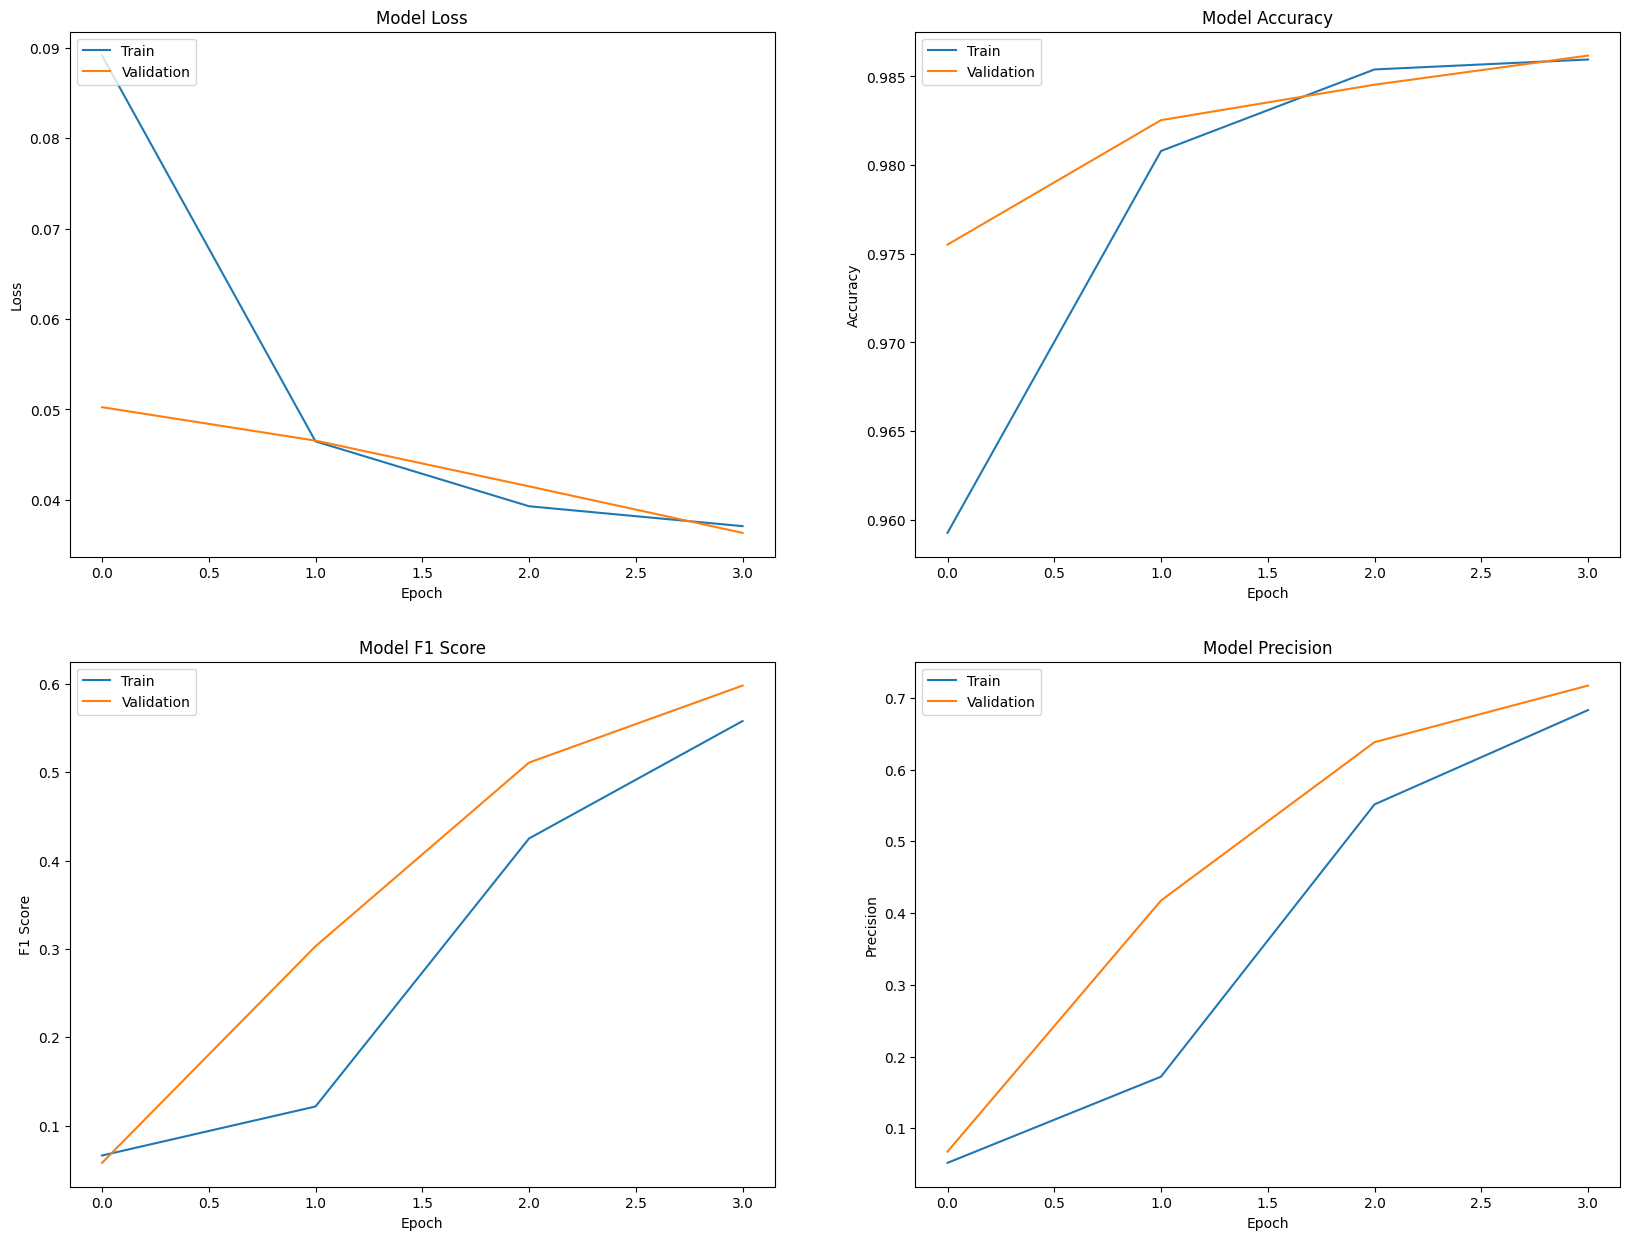

In [76]:
def plot_training_progress(name):
    print(f"Plotting training progress for: {name}")
    
    with open(f"save/history_{name}.pkl", "rb") as f:
        history_dict = pickle.load(f)
    
    fig, ((ax11, ax12), (ax13, ax14)) = plt.subplots(2, 2, figsize=(20, 15))

    ax11.plot(history_dict['loss'])
    ax11.plot(history_dict['val_loss'])
    ax11.set_title('Model Loss')
    ax11.set_ylabel('Loss')
    ax11.set_xlabel('Epoch')
    ax11.legend(['Train', 'Validation'], loc='upper left')

    ax12.plot(history_dict['accuracy'])
    ax12.plot(history_dict['val_accuracy'])
    ax12.set_title('Model Accuracy')
    ax12.set_ylabel('Accuracy')
    ax12.set_xlabel('Epoch')
    ax12.legend(['Train', 'Validation'], loc='upper left')

    ax13.plot(history_dict['f1_score'])
    ax13.plot(history_dict['val_f1_score'])
    ax13.set_title('Model F1 Score')
    ax13.set_ylabel('F1 Score')
    ax13.set_xlabel('Epoch')
    ax13.legend(['Train', 'Validation'], loc='upper left')

    ax14.plot(history_dict['precision'])
    ax14.plot(history_dict['val_precision'])
    ax14.set_title('Model Precision')
    ax14.set_ylabel('Precision')
    ax14.set_xlabel('Epoch')
    ax14.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

if TRAIN:
    plot_training_progress(MODEL_SAVED_NAME)
else:
    plot_training_progress("model_epoch_temp")

### Comparing confusion matrix for different models

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step


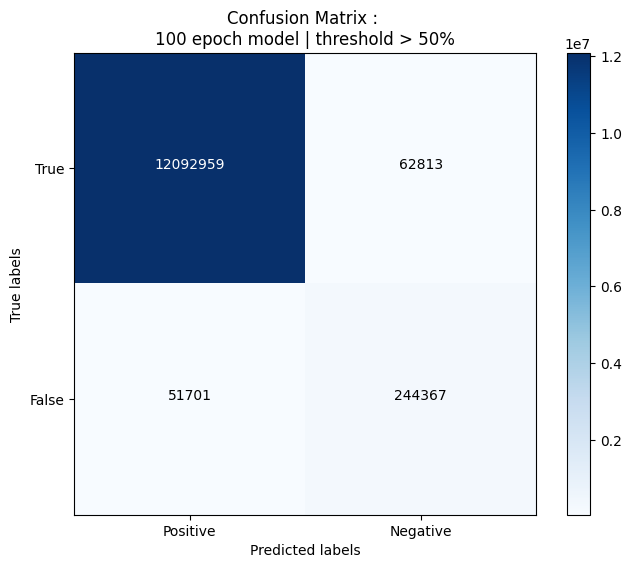

Confusion Matrix :
[[12092959    62813]
 [   51701   244367]]
Precision : 99 %
Recall : 98 %
Cumulative f1 score : 98 %
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step


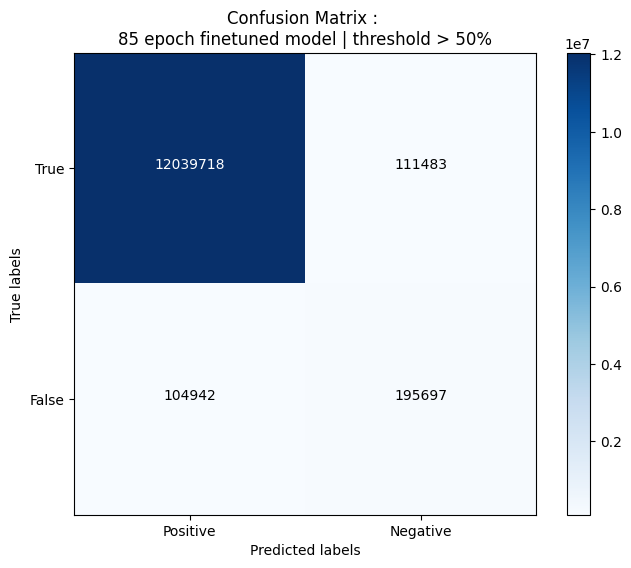

Confusion Matrix :
[[12039718   111483]
 [  104942   195697]]
Precision : 99 %
Recall : 98 %
Cumulative f1 score : 98 %
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step


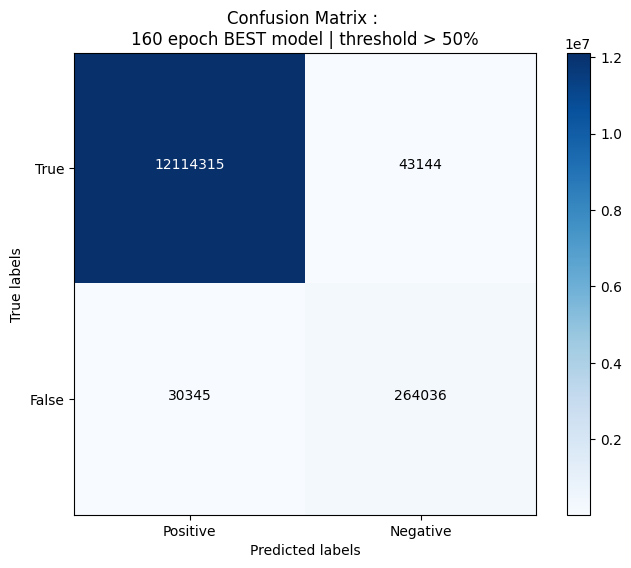

Confusion Matrix :
[[12114315    43144]
 [   30345   264036]]
Precision : 99 %
Recall : 97 %
Cumulative f1 score : 98 %


In [87]:
from sklearn.metrics import confusion_matrix
import numpy as np
def confusion_matrix_analysis(my_model,threshold = 0.05, txt="" ):
    pred_img = my_model.predict(x_valid)
    pred_img = (pred_img > threshold).astype(np.uint8)
    pred_img2 = (y_valid > threshold).astype(np.uint8)

    # computing confusion matrix
    y_true = pred_img[:, :, :, 0].flatten()                         # flatten the ground truth labels
    y_pred = pred_img2[:, :, :, 0].flatten()                        # flatten the predicted labels
    cm = confusion_matrix(y_true, y_pred)                           # x=actual,y=pred

    # plotting confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix : \n{txt} | threshold > {int(threshold*100)}%")
    plt.colorbar()
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(np.arange(2), ['Positive', 'Negative'])
    plt.yticks(np.arange(2), ['True', 'False'])

    # adding actual numbers to the plot
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.show()
    tp=cm[0,0]
    fp=cm[1,0]
    fn=cm[1,1]
    prec=tp/(tp+fp)
    rec=tp/(tp+fn)
    f1=2*prec*rec/(prec+rec)    # printing confusion matrix and other data
    print("Confusion Matrix :")
    print(cm)
    print(f"Precision : {int(prec*100)} %\nRecall : {int(rec*100)} %")
    print("Cumulative f1 score :",int(f1*100),"%")


model10epoch = tf.keras.models.load_model("./save/model_epoch_10.h5")
model100epoch = tf.keras.models.load_model("./save/model_save_100_84%.h5")
model160epoch_best = tf.keras.models.load_model("./save/model_epoch_160_valf1m0_0001_89%.h5")
model200epoch_finetuned = tf.keras.models.load_model("./save/model_epoch_85_200_finetune_120.h5")

confusion_matrix_analysis(model100epoch, threshold=0.50, txt="100 epoch model")
confusion_matrix_analysis(model200epoch_finetuned, threshold=0.50,  txt="85 epoch finetuned model")
confusion_matrix_analysis(model160epoch_best, threshold=0.50,  txt="160 epoch BEST model")

### Finding suitable threshold comparing multiple models

85 epoch finetuned model
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step


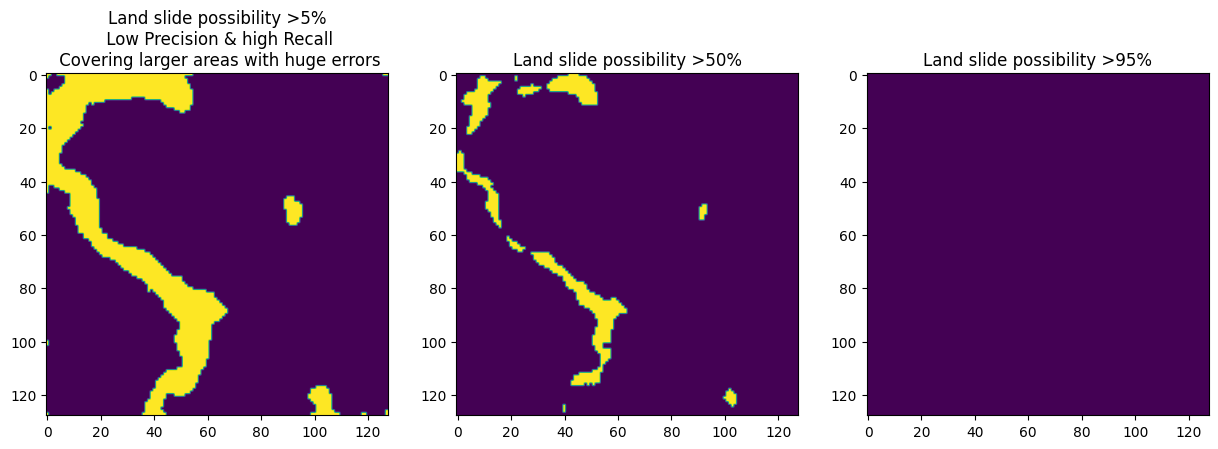

100 epoch model
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step


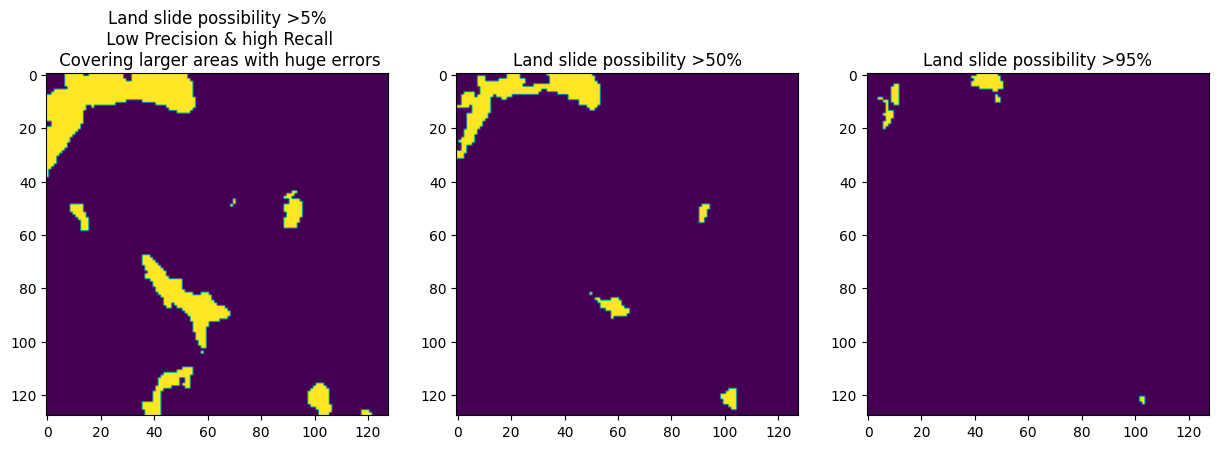

160 epoch BEST model
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step


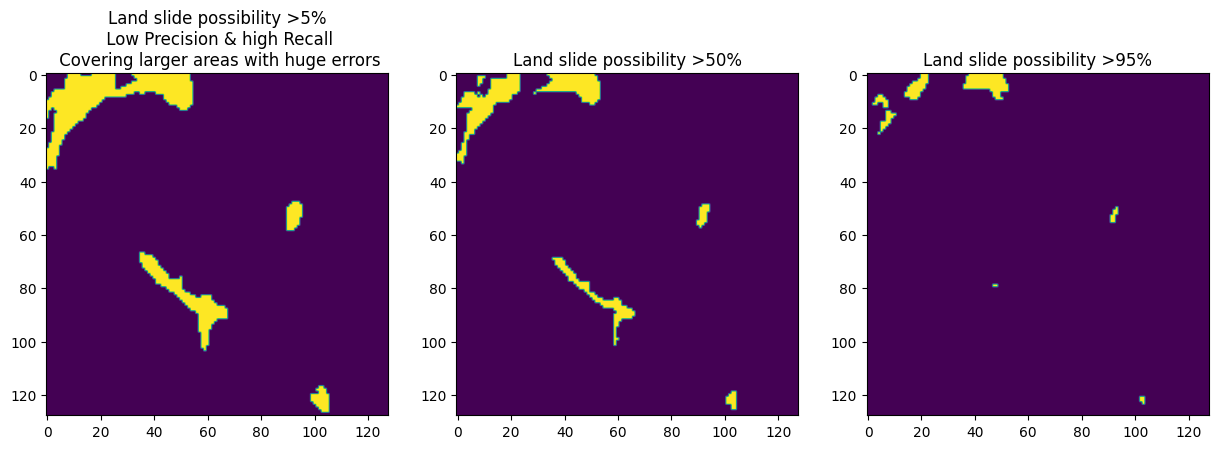

In [106]:
def analyzing_threshold(my_model,txt,img=129,threshold=[0.05, 0.5, 0.95]):
    print(txt)
    pred_img = my_model.predict(x_valid)
    pred_img_0 = (pred_img > threshold[0]).astype(np.uint8)

    fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
    ax1.imshow(pred_img_0[img, :, :, 0])
    ax1.set_title(f"Land slide possibility >{int(threshold[0]*100)}%\n Low Precision & high Recall\n Covering larger areas with huge errors")

    pred_img_25 = (pred_img > threshold[1]).astype(np.uint8)
    ax2.imshow(pred_img_25[img, :, :, 0])
    ax2.set_title(f"Land slide possibility >{int(threshold[1]*100)}%")

    pred_img_40 = (pred_img > threshold[2]).astype(np.uint8)
    ax3.imshow(pred_img_40[img, :, :, 0])
    ax3.set_title(f"Land slide possibility >{int(threshold[2]*100)}%")
    plt.show()
IMG_INDEX =125
IMG_INDEX =17
analyzing_threshold(model200epoch_finetuned, txt="85 epoch finetuned model", img=IMG_INDEX)
analyzing_threshold(model100epoch, txt="100 epoch model", img=IMG_INDEX)
# # analyzing_threshold(model10epoch, txt="10 epoch model",img=IMG_INDEX)
analyzing_threshold(model160epoch_best, txt="160 epoch BEST model", img=IMG_INDEX)

### Comparing prediction and label for different models

Model of 10 epoch
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step


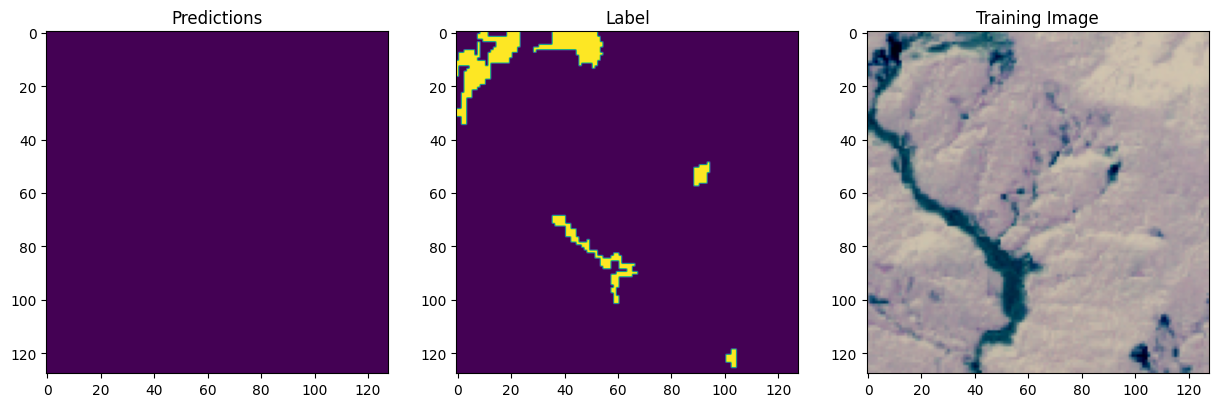

Model of 85 epoch FINETUNED
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step


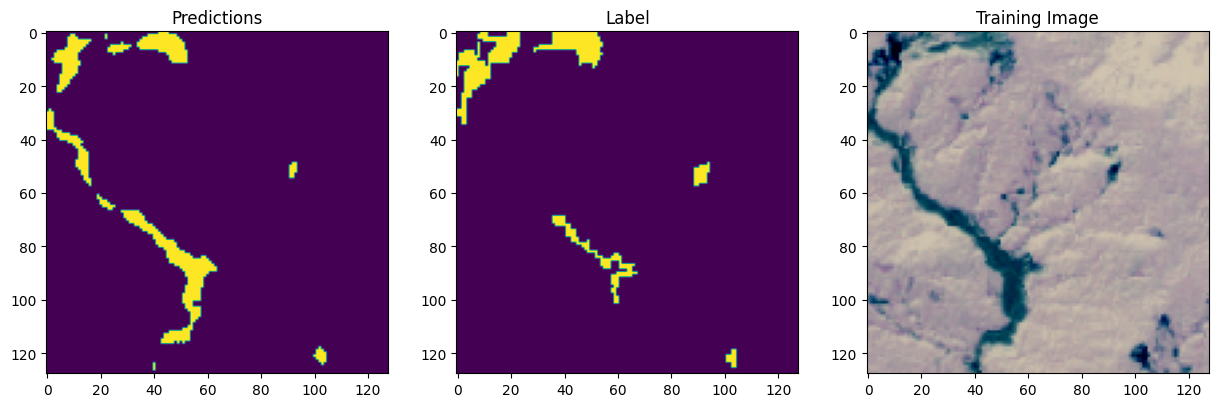

Model of 100 epoch
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step


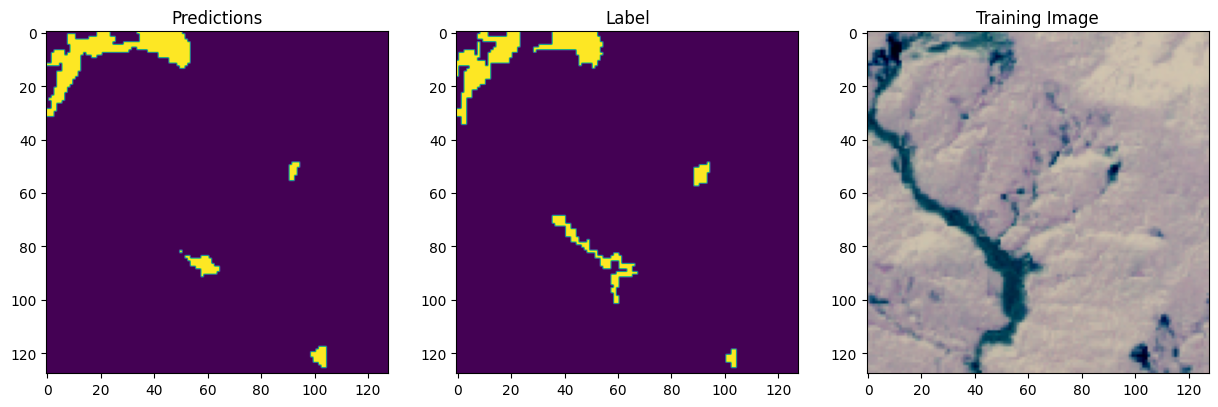

Model of 160 epoch BEST
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step


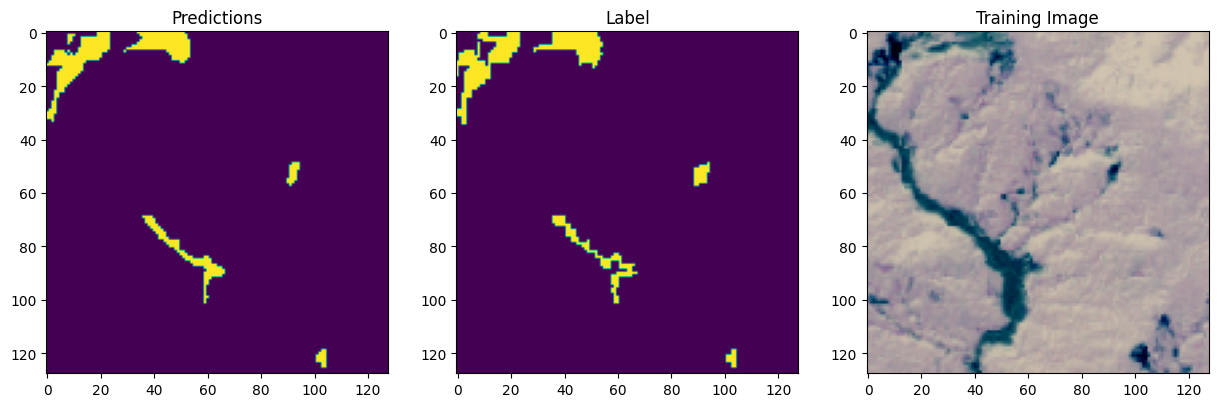

In [107]:
def analyzing_prediction(my_model,txt,img=272, threshold=0.5):
    print(txt)
    pred_img = my_model.predict(x_valid)
    pred_img = (pred_img > threshold).astype(np.uint8)
    fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
    ax1.imshow(pred_img[img, :, :, 0])
    ax1.set_title("Predictions")
    ax2.imshow(y_valid[img, :, :, 0])
    ax2.set_title("Label")
    ax3.imshow(x_valid[img, :, :, 0:3])
    ax3.set_title('Training Image')
    plt.show()
# img=np.random.randint(0,len(x_valid))
analyzing_prediction(model10epoch,"Model of 10 epoch", img=IMG_INDEX)
analyzing_prediction(model200epoch_finetuned, "Model of 85 epoch FINETUNED", img=IMG_INDEX)
analyzing_prediction(model100epoch, "Model of 100 epoch", img=IMG_INDEX)
analyzing_prediction(model160epoch_best, "Model of 160 epoch BEST", img=IMG_INDEX)

### Loading unmarked (un-labeled) data

In [80]:
# validation
predict_url = './archive/ValidData/img/*.h5'
img_val = sorted(glob.glob(predict_url))

UNKNOWN_XX = np.zeros((len(glob.glob(predict_url)), 128, 128, 6))
mask_name = []
for i, img in enumerate(img_val):
    # print(i, img)
    mask_name.append(img.split('/')[-1].replace('image', 'mask'))
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data 
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        # data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
        data_ndvi = np.divide(data_nir - data_red, np.add(data_red, data_nir) + 0.000001)
        
        # final array
        UNKNOWN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb #RED
        UNKNOWN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        UNKNOWN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        UNKNOWN_XX[i, :, :, 3] = data_ndvi #NDVI
        UNKNOWN_XX[i, :, :, 4] = 1- data[:, :, 13] / mid_slope #SLOPE
        UNKNOWN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION
print(f"Loaded {len(glob.glob(predict_url))} unlabaled data")

Loaded 245 unlabaled data


### Final prediction on unmarked data

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


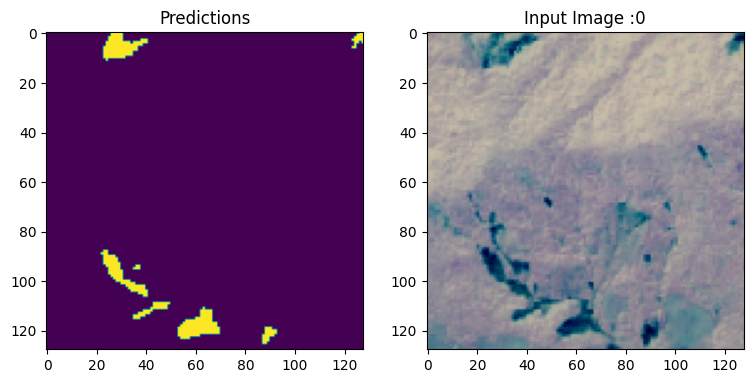

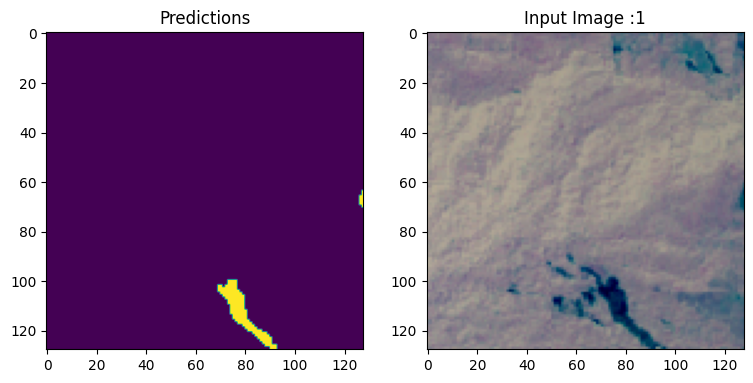

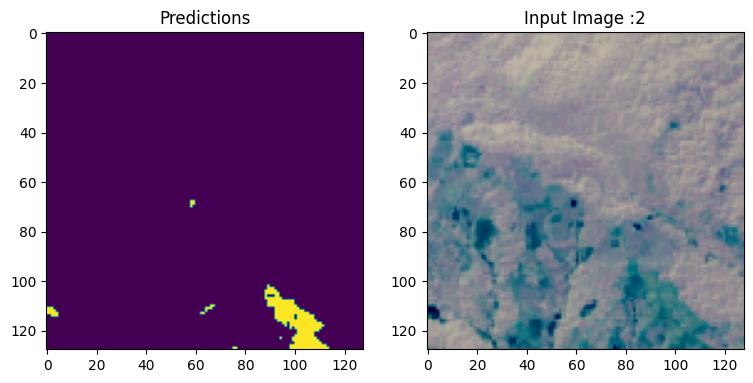

In [81]:
def predict_on_new_data(my_model, data= UNKNOWN_XX, images=[167, 33, 199]):
    threshold = 0.5
    pred_img = my_model.predict(data)
    pred_img = (pred_img > threshold).astype(np.uint8)
    pred_img.shape

    for i,img in enumerate(images):
        fig,(ax1,ax2)= plt.subplots(1,2,figsize=(9,9))
        ax1.imshow(pred_img[img, :, :, 0])
        ax1.set_title("Predictions")
        ax2.imshow(data[img, :, :, 0:3])
        ax2.set_title(f"Input Image :{i}")
        plt.show()
predict_on_new_data(model160epoch_best)